In [ ]:
%pip install google-genai
%pip install matplotlib
%pip install os
%pip install dotenv
%pip install pydantic

In [ ]:
from google import genai
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv
from google.genai import types
from pydantic import BaseModel, Field
from io import BytesIO
from PIL import Image
from IPython.display import Markdown

In [41]:
class GendersVerification(BaseModel):
    result: bool = Field(description="Whether the genders are opposite.")
    stop_reason: str | None = Field(None, description="The stop reason when result is False.")

In [40]:
def create_genai_client():
    import os

    api_key = os.getenv("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("GOOGLE_API_KEY not found in .env file")    

    # Configure the client with your API key
    client = genai.Client(api_key=api_key, http_options={'api_version': 'v1alpha'})

    return client

In [43]:
def load_image(image_path: str):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [44]:
def get_inline_data_part(image_path: str):
    import mimetypes

    try:
        mime_type, _ = mimetypes.guess_type(image_path)
        if mime_type is None:
            mime_type = 'application/octet-stream'
            print(f"Warning: Could not determine MIME type for {image_path}. Defaulting to {mime_type}.")

        file_bytes: bytes | None = None
        with open(image_path, "rb") as image_file:
            file_bytes = image_file.read()
        
        if file_bytes is None:
            raise Exception(f"Unable to read the bytes from {image_path}")
    
        return types.Part(
            inline_data=types.Blob(
                mime_type=mime_type,
                data=file_bytes
            ),
            media_resolution={"level": "media_resolution_high"}
        ) 
    except FileNotFoundError:
        print (f"Error: The file was not found at {image_path}")
    except Exception as e:
        print (f"An error occurred: {e}")

In [45]:
def print_token_usage(response: types.GenerateContentResponse):
    if response and response.usage_metadata:
        usage_metadata = response.usage_metadata
        input_token_count = usage_metadata.prompt_token_count
        output_token_count = usage_metadata.candidates_token_count
        total_token_count = usage_metadata.total_token_count
        thought_token_count = usage_metadata.thoughts_token_count
        cached_token_count = usage_metadata.cached_content_token_count
        print(f"Input: {input_token_count}, Output: {output_token_count}, Thought: {thought_token_count}, Cached: {cached_token_count} Total: {total_token_count}")

In [46]:
load_dotenv()

# Configure the client with your API key
client = create_genai_client()

In [47]:
tools = [types.Tool(google_search=types.GoogleSearch())]

def verify_genders(person_a_image: str, person_b_image: str):
    gender_verification_prompt = """
    Role: You are an Advanced Image Content Validator. Your goal is to identify human subjects for a biological analysis tool, even in complex images.

    Task: Analyze two input images (Image A and Image B). Locate the primary human subject in each image and verify their genders.

    Validation & Selection Logic:

    1. Smart Subject Detection:
    - Scan each image for a human face or figure.
    - Crucial: If an image contains both humans and objects (e.g., a person holding a guitar, a person next to a car, or a person in a cluttered room), you must ignore the objects and focus exclusively on the human.
    - If multiple humans are present, select the most prominent/clearest face as the subject for that image.
    - Failure Condition: If no recognizable human face is found in one or both images (e.g., only a landscape, animal, or object is visible), set "result" to false and "stop_reason" to "One or both images do not contain a detectable human face."

    2. Gender Verification:
    - Analyze the biological sex or gender presentation of the selected human subject in Image A and Image B.
    - Failure Condition: If the subjects are of the same gender (Male+Male or Female+Female), set "result" to false and "stop_reason" to "Please upload one male and one female."

    3. Pass Condition:
    - If both images contain a human subject AND they are of opposite genders (One Male + One Female), set "result" to true and "stop_reason" to null.

    Output Schema:
    Return ONLY a single JSON object with no markdown formatting or additional text.

    {
    "result": boolean,
    "stop_reason": string | null
    }
    """
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[
            types.Content(
                parts=[
                    types.Part(text=gender_verification_prompt),
                    get_inline_data_part(person_a_image),
                    get_inline_data_part(person_b_image),
                ]
            )
        ],
        config=types.GenerateContentConfig(
            response_mime_type="application/json",
            response_json_schema=GendersVerification.model_json_schema(),
            tools=tools
        )
    )

    print_token_usage(response)
    result = GendersVerification.model_validate_json(response.text)
    return result

In [ ]:
def generate_sibling_images(person_a_image: str, person_b_image: str):
    prompt = """
    A group portrait of four distinct young adult siblings (two males, two females, aged 18-22). 
    They are the biological offspring of the provided references, generated with **high genetic variability**. 
    The faces must display a **randomized distribution of traits**, where features (eyes, nose, mouth, jawline) are mixed **unequally** across the four subjects. 
    Ensure distinctiveness: Sibling 1 should lean strongly towards the father's features, Sibling 2 towards the mother's, while Siblings 3 and 4 represent complex, unique mixes of recessive and dominant traits. 
    **Crucial:** All four must have fresh, smooth, youthful skin and collegiate appearances. 
    Do not transfer the parents' wrinkles or skin texture. 2k resolution, photorealistic, detailed distinct faces.
    """

    response = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        contents=[
            types.Content(
                parts=[
                    types.Part(text=prompt),
                    get_inline_data_part(person_a_image),
                    get_inline_data_part(person_b_image),
                ]
            )
        ],
        config=types.GenerateContentConfig(
            response_modalities=['TEXT', 'IMAGE'],
            image_config=types.ImageConfig(
                image_size="2K",  
            ),
            tools=tools,
            thinking_config=types.ThinkingConfig(
                include_thoughts=True
            ),
            temperature=0.5
        )
    )

    print_token_usage(response)

    image_bytes: bytes | None = None
    if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
        for part in response.candidates[0].content.parts:
            if part.thought and part.text:
                display(Markdown(f"Though Summary:\n {part.text}"))
            elif part.text:
                print("Text: ", part.text)
            if part.inline_data:
                image_bytes = part.inline_data.data
       
    return image_bytes

In [49]:
def print_result(person_a_image: str, person_b_image: str):
    load_image(person_a_image)
    load_image(person_b_image)

    result = verify_genders(person_a_image=person_a_image, person_b_image=person_b_image)
    if result.result:
        offspring_bytes = generate_sibling_images(person_a_image, person_b_image)
        offspring_image = Image.open(BytesIO(offspring_bytes)) if offspring_bytes else None
        if offspring_image:
            plt.imshow(offspring_image)
            plt.axis('off')
            plt.show()
        pass
    else:
        if result.stop_reason:
            print ("Stop reason:", result.stop_reason)

def print_test_cases(heading: str, cases: list[list[str]]):
    print(heading)
    for case in cases:
        print_result(person_a_image=case[0], person_b_image=case[1])

In [ ]:
print_test_cases(heading="Same gender cases (Expected failure)", cases=[
    ['./couples/prince_william.jpg', './couples/david_beckham.webp']
])

In [ ]:
print_test_cases(heading="Couple cases", cases=[
    ['./couples/prince_william.jpg', './couples/princess_kate.jpg'],
])

In [ ]:
print_test_cases(heading="Couple cases", cases=[
    ['./couples/victoria_beckham.jpg', './couples/david_beckham.webp']
])

Couple cases


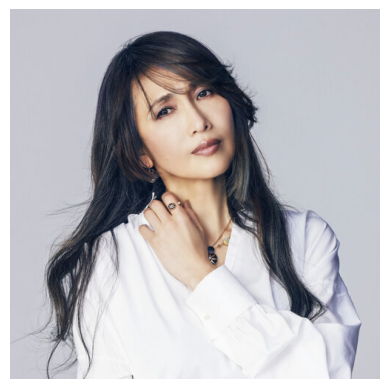

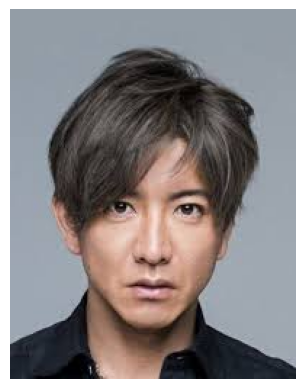

Input: 2578, Output: 17, Thought: 287, Cached: None Total: 2882


In [ ]:
print_test_cases(heading="Couple cases", cases=[
    ['./couples/Shizuka_Kudo.jpg', './couples/Takuya_Kimura.jpg'],
])